In [9]:
# Import ML libs
import math
import numpy as np
import pandas as pd
from math import sqrt
from numpy import split
from numpy import array

# Import Keras libs
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.metrics import mean_squared_error
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Import required libraries for visualization and printing
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import utility for time manupulation
import datetime
import time

#Import other libs
import os
from pathlib import Path

# Import libs for stock market datasets
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

# Max allowed time delta
ALLOWED_DELTA = datetime.timedelta(days=7) 
model = None
predictions = None

def get_date():
    """ Return date in yyyy-mm-dd format """
    now = datetime.datetime.now()
    return now.strftime("%Y-%m-%d")

def save_data(df,fileName):
    """ Saves data to csv file, file name is Ticker symbol """
    df.to_csv("data\\" + fileName)
    
def load_data(fileName):
    """ Load data from csv file, file name is Ticker symbol """
    return pd.read_csv("data\\" + fileName,infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
    
def data_exists(fileName):
    """ Check if file exists in data"""
    my_file = Path("data\\" + fileName )
    res = my_file.is_file()
    return res
    
def get_data(symbol, start_date='2000-01-01'):
    """ Download and return stock data """
    download_data = True
    if data_exists(symbol):
        # file exists
        data = load_data(symbol)
        #if date is current do not download data
        c_date = data.iloc[-1,0]
        if pd.to_datetime(get_date()) - pd.to_datetime(c_date) < ALLOWED_DELTA:
            download_data = False
    if download_data :  
        try:
            yf.pdr_override()
            # download dataframe
            data = pdr.get_data_yahoo(symbol, start=start_date)
        except ValueError:
            pass
        if Path(symbol).is_file():
            os.remove(symbol)
        save_data(data,symbol)
    return load_data(symbol)


def fill_missing_values(df_data):
    """Fill missing values in data frame, in place."""
    df_data.fillna(method='ffill',inplace=True)  
    df_data.fillna(method='bfill',inplace=True)
    return df_data

def plot_val_data(df, val ,title="Plot Stock Feature",):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df[val].plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel(val)
    plt.show()
    
#split for train and test
def split_dataset (df, window = 7, train_percent = 0.7):
    number_of_rows = int(df.shape[0] / window) * window
    fd = df[-number_of_rows:]
    trfd_rows = int(int(fd.shape[0] * train_percent) / window) * window
    trfd = fd [:trfd_rows]
    tsfd_rows = int((df.shape[0] - trfd_rows) / window) * window
    tsfd = fd[-tsfd_rows:]
    trfd = array(split(trfd, len(trfd)/window))
    tsfd = array(split(tsfd, len(tsfd)/window))
    print(trfd.shape,tsfd.shape)
    return trfd,tsfd

# plot prediction vs actual
def plot_pred_v_test(predictions,test,show_last=100):
    test_base = test.reshape(-1,10)
    test_df = pd.DataFrame(test_base)
    predictions_r = predictions.reshape(-1,1)
    print(predictions_r.T[0,-7:])
    print(test_df.iloc[-7:,0].values)
    plt.plot(predictions_r.T[0,-100:],label="Predicted")
    plt.plot(test_df.iloc[-100:,0].values,label="Actual")  
    plt.title('Actual vs Predicted',fontsize=10)
    plt.xlabel('Last '+str(show_last)+' Days',fontsize=10)
    plt.ylabel('Adj Close Price (USD)',fontsize=10)
    plt.legend()
    plt.show()


In [10]:
# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

#split for train and test
def split_dataset (df, window = 7, train_percent = 0.7):
    number_of_rows = int(df.shape[0] / window) * window
    fd = df[-number_of_rows:]
    trfd_rows = int(int(fd.shape[0] * train_percent) / window) * window
    trfd = fd [-trfd_rows:]
    tsfd_rows = int((df.shape[0] - trfd_rows) / window) * window
    tsfd = fd[:tsfd_rows]
    trfd = array(split(trfd, len(trfd)/window))
    tsfd = array(split(tsfd, len(tsfd)/window))
    print(trfd.shape,tsfd.shape)
    return trfd,tsfd

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_steps, n_length, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 1, 20, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [samples, time steps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=1)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
	# fit model
	model = build_model(train, n_steps, n_length, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores , predictions


In [11]:
def run_LSTM(ticker,lookback=100,daysInFuture=7):
    # load the new file
    dataset = load_data(ticker+'_processed')
    # split into train and test
    train, test = split_dataset(dataset.values)
    # define the number of subsequences and the length of subsequences
    n_steps, n_length = 2, 7
    # define the total days to use as input
    n_input = n_length * n_steps
    score, scores, predicted = evaluate_model(train, test, n_steps, n_length, n_input)
    # summarize scores
    summarize_scores('lstm', score, scores)
    # plot scores
    days = []
    for i in range(daysInFuture):
        days.append('day'+str(i))
    plt.plot(days, scores, marker='o', label='lstm')
    plt.show()
    return predicted,test
    

In [12]:
### Run Models for all tickers

(477, 7, 10) (205, 7, 10)
Epoch 1/20
3318/3318 [==============================] - 11s 3ms/step - loss: 386.5817
Epoch 2/20
3318/3318 [==============================] - 9s 3ms/step - loss: 24.7017
Epoch 3/20
3318/3318 [==============================] - 8s 3ms/step - loss: 18.7610
Epoch 4/20
3318/3318 [==============================] - 8s 2ms/step - loss: 16.5815
Epoch 5/20
3318/3318 [==============================] - 8s 2ms/step - loss: 15.3265
Epoch 6/20
3318/3318 [==============================] - 8s 2ms/step - loss: 16.9103
Epoch 7/20
3318/3318 [==============================] - 9s 3ms/step - loss: 17.5828
Epoch 8/20
3318/3318 [==============================] - 9s 3ms/step - loss: 15.3961
Epoch 9/20
3318/3318 [==============================] - 8s 2ms/step - loss: 17.1775
Epoch 10/20
3318/3318 [==============================] - 8s 2ms/step - loss: 15.9543
Epoch 11/20
3318/3318 [==============================] - 8s 3ms/step - loss: 14.3795
Epoch 12/20
3318/3318 [=======================

1/1 [==============================] - 0s 3ms/step
lstm: [4.866] 3.4, 3.8, 4.3, 4.9, 5.3, 5.7, 6.1


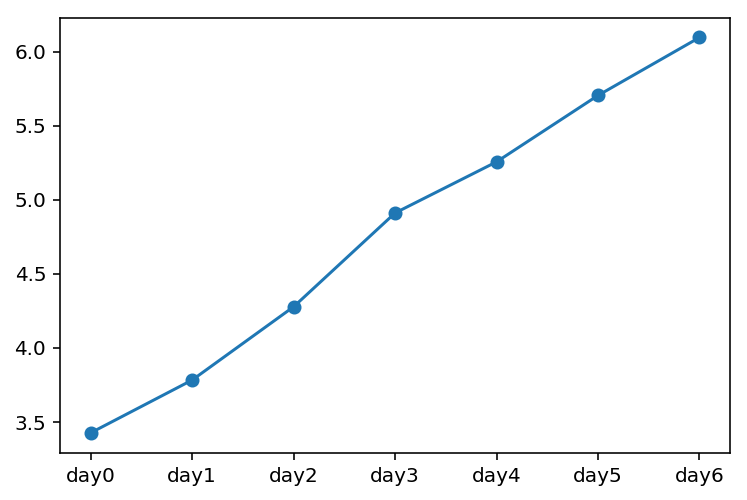

[57.341793 56.971935 57.2455   58.243584 58.436863 58.729904 58.74966 ]
[55.985165 57.069138 57.686485 57.585976 57.75108  57.507011 57.298817]


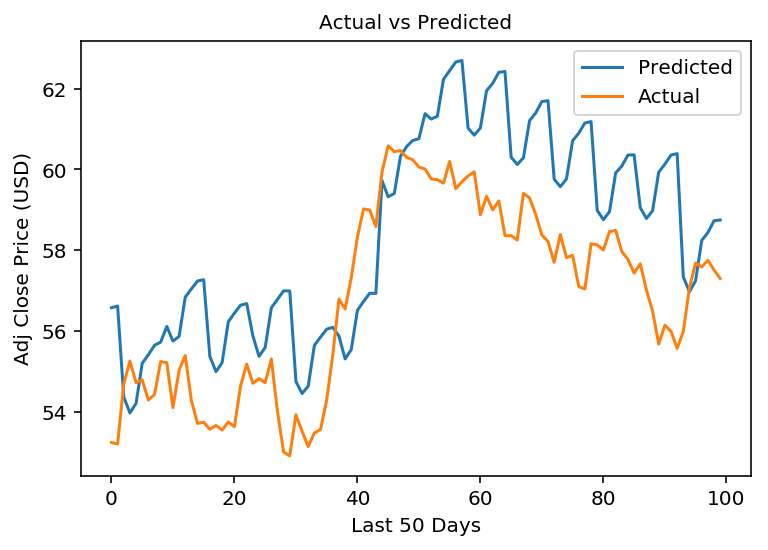

In [13]:
#for IBM
pred, tes = run_LSTM('IBM',14)
plot_pred_v_test(pred, tes,50)

(477, 7, 10) (205, 7, 10)
Epoch 1/20
3318/3318 [==============================] - 11s 3ms/step - loss: 166.2413
Epoch 2/20
3318/3318 [==============================] - 10s 3ms/step - loss: 27.7800
Epoch 3/20
3318/3318 [==============================] - 9s 3ms/step - loss: 19.3453
Epoch 4/20
3318/3318 [==============================] - 10s 3ms/step - loss: 16.2847
Epoch 5/20
3318/3318 [==============================] - 10s 3ms/step - loss: 17.4460
Epoch 6/20
3318/3318 [==============================] - 10s 3ms/step - loss: 13.8178
Epoch 7/20
3318/3318 [==============================] - 12s 4ms/step - loss: 14.1922
Epoch 8/20
3318/3318 [==============================] - 10s 3ms/step - loss: 15.6199
Epoch 9/20
3318/3318 [==============================] - 9s 3ms/step - loss: 15.2351
Epoch 10/20
3318/3318 [==============================] - 9s 3ms/step - loss: 15.6574
Epoch 11/20
3318/3318 [==============================] - 9s 3ms/step - loss: 15.2177
Epoch 12/20
3318/3318 [=================

1/1 [==============================] - 0s 2ms/step
lstm: [10.491] 10.3, 10.3, 10.4, 10.5, 10.6, 10.6, 10.6


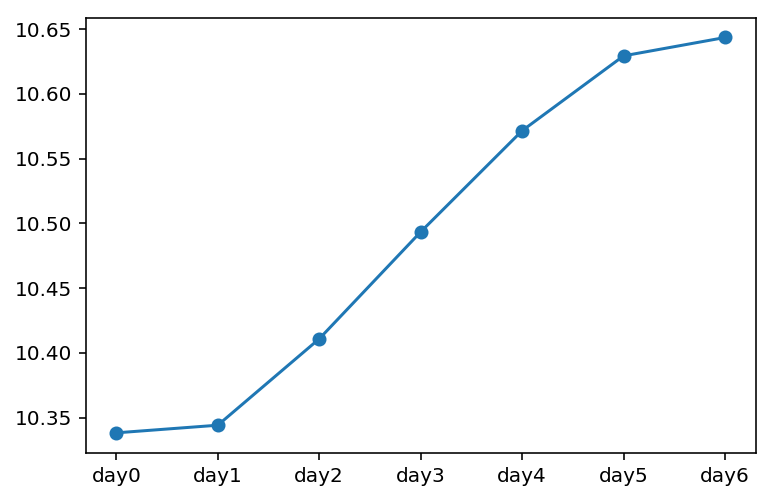

[5.174469  5.322857  5.386846  5.4734077 5.5517035 5.64186   5.715478 ]
[5.112397 4.886624 5.007164 5.128659 5.208063 5.142054 5.049257]


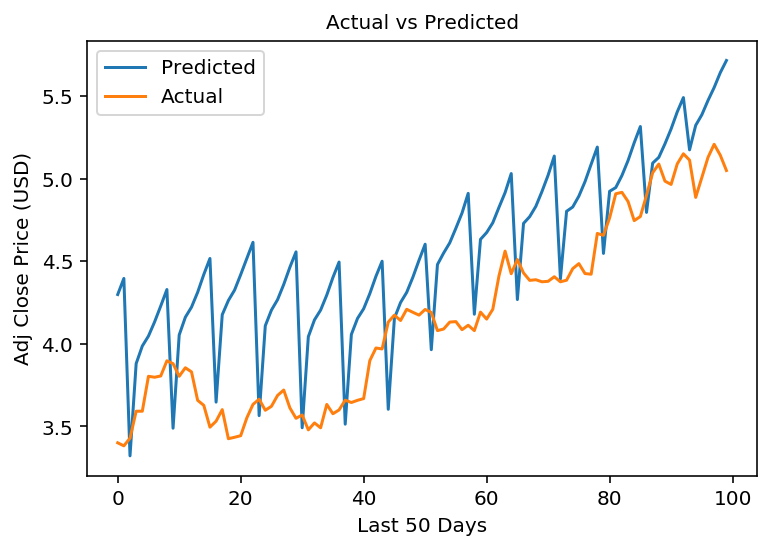

In [14]:
#for apple
pred, tes = run_LSTM('AAPL',14)
plot_pred_v_test(pred, tes,50)

(477, 7, 10) (205, 7, 10)
Epoch 1/20
3318/3318 [==============================] - 12s 4ms/step - loss: 76.3915
Epoch 2/20
3318/3318 [==============================] - 10s 3ms/step - loss: 3.5881
Epoch 3/20
3318/3318 [==============================] - 10s 3ms/step - loss: 4.2906
Epoch 4/20
3318/3318 [==============================] - 10s 3ms/step - loss: 2.6875
Epoch 5/20
3318/3318 [==============================] - 9s 3ms/step - loss: 2.9343
Epoch 6/20
3318/3318 [==============================] - 9s 3ms/step - loss: 4.2691
Epoch 7/20
3318/3318 [==============================] - 10s 3ms/step - loss: 4.6990
Epoch 8/20
3318/3318 [==============================] - 10s 3ms/step - loss: 2.7987
Epoch 9/20
3318/3318 [==============================] - 11s 3ms/step - loss: 3.3497
Epoch 10/20
3318/3318 [==============================] - 10s 3ms/step - loss: 2.8159
Epoch 11/20
3318/3318 [==============================] - 11s 3ms/step - loss: 2.5562
Epoch 12/20
3318/3318 [==========================

1/1 [==============================] - 0s 3ms/step
lstm: [5.007] 4.8, 5.0, 4.9, 5.1, 5.1, 5.1, 5.1


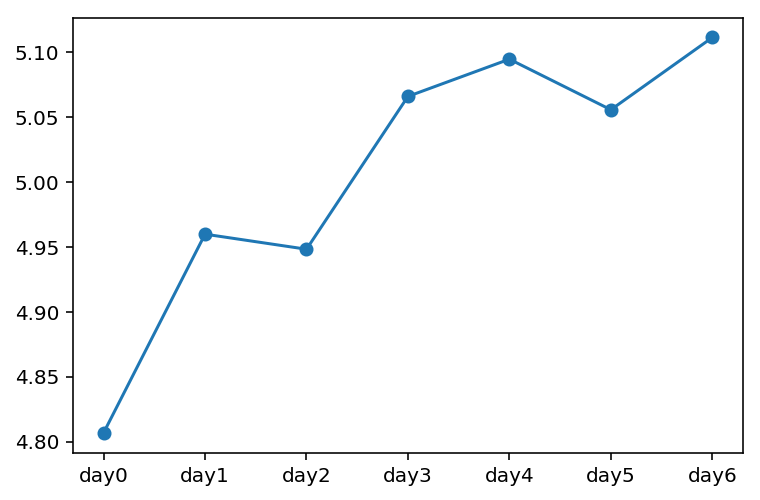

[19.336687 19.298578 19.304857 19.208464 19.218447 19.25078  19.211544]
[18.82921  19.074423 19.275042 19.119001 18.948101 18.561705 18.331358]


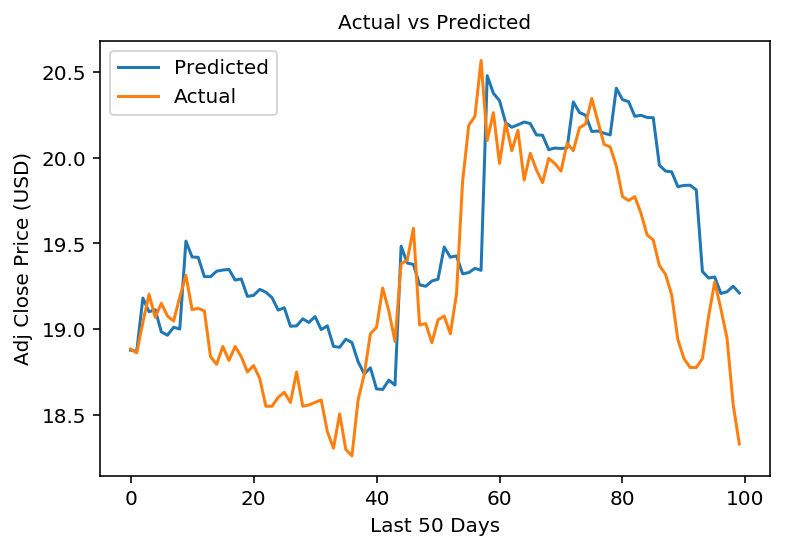

In [15]:
#for microsoft
pred, tes = run_LSTM('MSFT',14)
plot_pred_v_test(pred, tes,50)

(477, 7, 10) (205, 7, 10)
Epoch 1/20
3318/3318 [==============================] - 12s 4ms/step - loss: 17829.6665
Epoch 2/20
3318/3318 [==============================] - 11s 3ms/step - loss: 1892.7016
Epoch 3/20
3318/3318 [==============================] - 11s 3ms/step - loss: 1381.3686 
Epoch 4/20
3318/3318 [==============================] - 10s 3ms/step - loss: 1219.5572
Epoch 5/20
3318/3318 [==============================] - 11s 3ms/step - loss: 1292.0488
Epoch 6/20
3318/3318 [==============================] - 12s 3ms/step - loss: 2387.7412
Epoch 7/20
3318/3318 [==============================] - 12s 4ms/step - loss: 1211.1879
Epoch 8/20
3318/3318 [==============================] - 11s 3ms/step - loss: 1091.4383
Epoch 9/20
3318/3318 [==============================] - 11s 3ms/step - loss: 1169.5847
Epoch 10/20
3318/3318 [==============================] - 10s 3ms/step - loss: 1184.5135
Epoch 11/20
3318/3318 [==============================] - 10s 3ms/step - loss: 1252.2087
Epoch 12/20
3

1/1 [==============================] - 0s 3ms/step
lstm: [110.845] 112.4, 111.0, 111.4, 111.4, 110.6, 109.5, 109.5


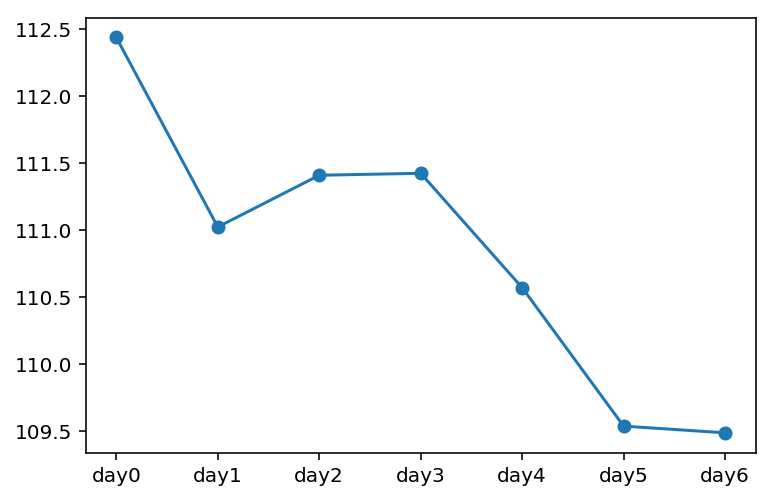

[44.11948  44.203938 44.612038 44.197075 44.05969  43.848198 43.850857]
[43.16     43.369999 44.790001 45.299999 46.009998 44.93     44.490002]


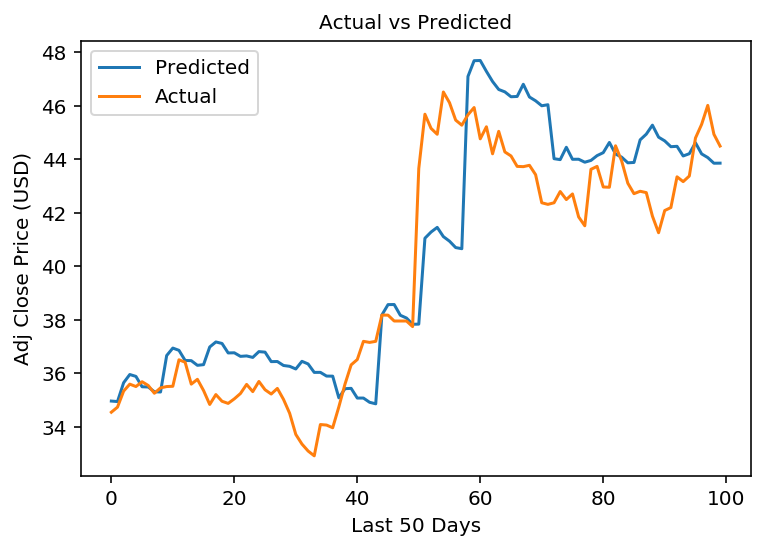

In [16]:
#for Amazon 
pred, tes = run_LSTM('AMZN',14)
plot_pred_v_test(pred, tes,50)

## Results 

In [ ]:
IBM      : lstm: [3.811] 2.6, 3.0, 3.3, 3.5, 4.1, 4.6, 5.0
Apple    : lstm: [15.809] 15.1, 15.8, 15.0, 16.0, 16.9, 15.2, 16.5
Amazon   : lstm: [35.133] 17.6, 25.3, 27.6, 32.5, 34.9, 45.6, 50.7
Microsoft: lstm: [3.292] 2.2, 2.4, 2.6, 3.1, 3.4, 4.0, 4.6